# Solve CartPole using DQN with 1000 steps

https://gym.openai.com/envs/CartPole-v0/

Some useful resources:
  * https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/
  
 CartPole is considered solved if the simulation is run for 200 steps.
 In this notebook the goal is to solve this environment for 1 000 steps.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import matplotlib.pyplot as plt
import gym

import agents
from agents import dqn

from IPython.display import clear_output
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Explore environment

Observation shape: (4,)
Number of actions: 2
Example state: [-0.03229575 -0.04808946  0.00406854 -0.02522067]


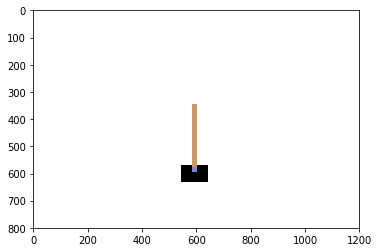

In [2]:
#spawn game instance for tests
env = gym.make("CartPole-v0") #create raw env

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape: {}".format(observation_shape))
print("Number of actions: {}".format(n_actions))

print("Example state: {}".format(env.reset()))
plt.imshow(env.render('rgb_array'))

# Build DQN Agent

In [3]:
class DQNAgent:
    
    def __init__(self, network):
        self.memory_capacity = 100000
        self.epsilon_min = 0.01
        self.epsilon_max = 0.01
        self.epsilon_lambda = 0.001
        self.batch_size = 64
        self.epsilon = self.epsilon_max        
        self.model = network
        self.replays = agents.ReplayBuffer(self.memory_capacity)
        self.step = 0
        
    def collect_policy(self, state):
        """Policy for experience collecting. Epsilon greedy"""
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, network.output_shape)
        else:
            qvalues = self.model.predict(state)
            action = np.argmax(qvalues)
            self.step += 1
        self.epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.power(np.e, self.epsilon_lambda*self.step)
        return action
    
    def evaluate_policy(self, state):
        """Policy for agent evaluation. Greedy"""
        qvalues = self.model.predict(state)
        action = np.argmax(qvalues)
        return action
    

    def add_observation(self, state, action, reward, next_state, is_done):
        self.replays.add(state, action, reward, next_state, is_done)
        
    def train(self):
        states, actions, rewards, states_next, dones = self.replays.sample(self.batch_size)
        qvalues = self.model.predict_batch(states)
        qvalues_next = self.model.predict_batch(states_next)
        y = agents.build_training_set(qvalues, qvalues_next, actions, rewards, dones)
        self.model.train(states, y)
    
    
# Test
network = dqn.QNetwork(observation_shape, n_actions)
agent = DQNAgent(network)
s1 = env.reset()
a = agent.collect_policy(s1)
s2, r, d, _ = env.step(a)
agent.add_observation(s1, a, r, s2, d)
agent.train()
a

0

# Solve Environment

## Helper functions for training and evaluation

In [4]:
def solve_env(env, agent, max_sessions=2000, t_max=200, solved=190):
    rewards = []
    for i in range(1, max_sessions+1):
        session_reward = agents.train_on_episode(env, agent, t_max)
        rewards.append(session_reward)
        if i % 100 == 0:
            mean_score = np.mean(rewards[-100:])
            clear_output(True)
            print('Step: {}, mean reward: {}'.format(i, mean_score))
            plt.plot(rewards)
            plt.show()
            if mean_score > solved:
                print("Solved in {} steps".format(i))
                break
    return rewards


def evaluate_agent(env, agent, max_sessions=500, t_max=200):
    rewards = []
    for i in range(1, max_sessions+1):
        session_reward = agents.evaluate_episode(env, agent, t_max)
        rewards.append(session_reward)
        if i % 100 == 0:
            mean_score = np.mean(rewards[-100:])
            clear_output(True)
            print('Step: {}, mean reward: {}'.format(i, mean_score))
            plt.plot(rewards)
            plt.show()

## Solve for 1000 steps

Step: 2000, mean reward: 306.56


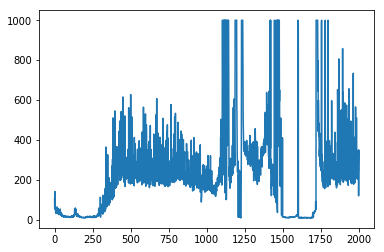

Done.


In [20]:
agent_1k = DQNAgent(dqn.QNetwork(observation_shape, n_actions))
solve_env(env, agent_1k, t_max=1000, solved=900)
print('Done.')

### Evaluate this agent

Step: 100, mean reward: 281.42


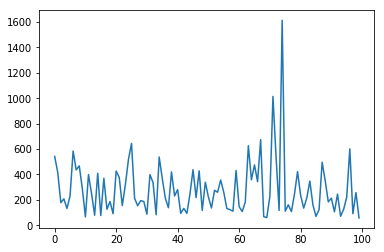

Done.


In [22]:
evaluate_agent(env, agent_1k, max_sessions=100, t_max=2000)
print('Done.')

Overfits?